In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

In [3]:
TRAIN_DIR = '/content/drive/MyDrive/Fruit Freshnes/dataset/train'
TEST_DIR = '/content/drive/MyDrive/Fruit Freshnes/dataset/test'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_gen = ImageDataGenerator(rescale = 1./255)

train_data = train_gen.flow_from_directory(
     TRAIN_DIR,
     target_size =IMG_SIZE,
     batch_size = BATCH_SIZE,
     class_mode = 'categorical'
)


test_data = test_gen.flow_from_directory(TEST_DIR,
                                         target_size=IMG_SIZE,
                                         batch_size=BATCH_SIZE,
                                         class_mode="categorical",
                                         shuffle=False)

num_classes = (train_data.num_classes)
print("No of Classes:",num_classes)
class_names = list(train_data.class_indices.keys())
print("Detected Classes:",class_names)

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.
No of Classes: 6
Detected Classes: ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']


In [4]:
base_model = MobileNetV2(weights = 'imagenet',include_top = False, input_shape = (*IMG_SIZE,3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(num_classes, activation = 'softmax')
])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_data,
    epochs=10,
    validation_data=test_data,
    callbacks=[early_stop]
)


print("\nEvaluating on Test Set...")
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")

pred = model.predict(test_data)
pred_labels = np.argmax(pred, axis=1)

print("\nClassification Report:")
print(classification_report(test_data.classes, pred_labels, target_names=class_names))

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 3086s 9s/step - accuracy: 0.8593 - loss: 0.3902 - val_accuracy: 0.9755 - val_loss: 0.0676
Epoch 2/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 854s 3s/step - accuracy: 0.9742 - loss: 0.0722 - val_accuracy: 0.9744 - val_loss: 0.0649
Epoch 3/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 832s 2s/step - accuracy: 0.9845 - loss: 0.0503 - val_accuracy: 0.9878 - val_loss: 0.0312
Epoch 4/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 849s 2s/step - accuracy: 0.9875 - loss: 0.0379 - val_accuracy: 0.9878 - val_loss: 0.0360
Epoch 5/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 854s 2s/step - accuracy: 0.9889 - loss: 0.0300 - val_accuracy: 0.9833 - val_loss: 0.0505
Epoch 6/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 884s 3s/step - accuracy: 0.9847 - loss: 0.0433 - val_accuracy: 0.9811 - val_loss: 0.0492

Evaluating on Test Set...
85/85 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9839 - loss: 0.0421
Test Accuracy: 0.99
85/85 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step

Classification Report:
               precision    recall  f1-s

In [40]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def predict_fruit(image_path):
    img = image.load_img(image_path, target_size=IMG_SIZE)
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    idx = np.argmax(predictions)
    fruit_class = class_names[idx]
    confidence = float(predictions[0][idx])
    print(f"Predicted: {fruit_class} | Confidence: {confidence:.2f}")
    return fruit_class, confidence

predict_fruit("/content/drive/MyDrive/Fruit Freshnes/dataset/test/freshapples/Screen Shot 2018-06-08 at 4.59.44 PM.png")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Predicted: freshapples | Confidence: 1.00


('freshapples', 0.9999843835830688)

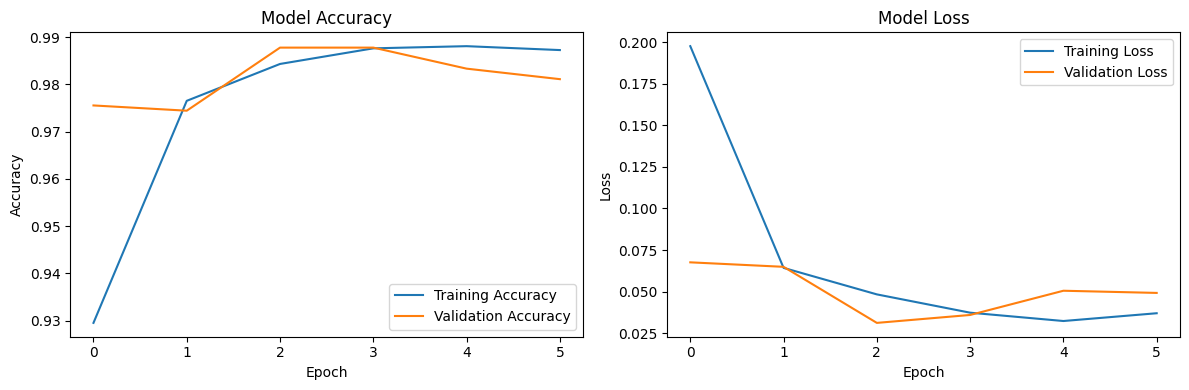

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

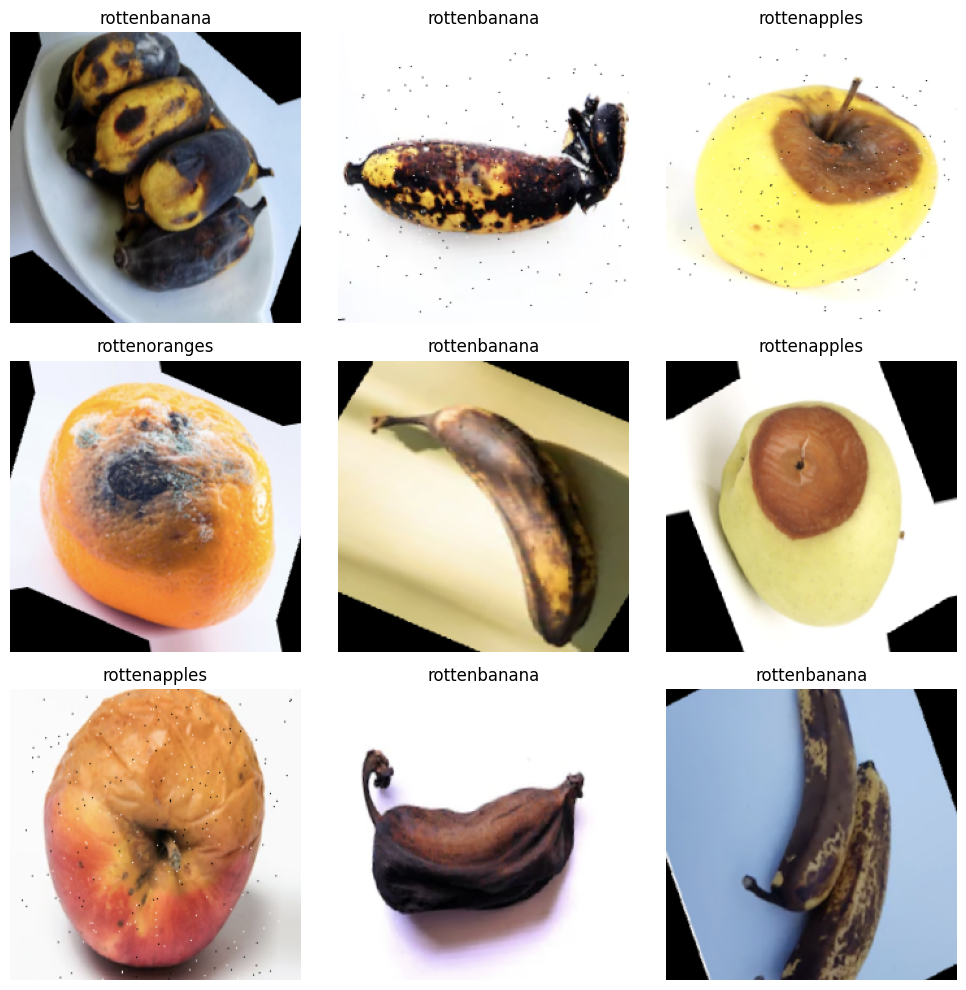

In [24]:
import matplotlib.pyplot as plt
images, labels = next(train_data)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(list(train_data.class_indices.keys())[np.argmax(labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()


 Selected Grad-CAM Layer: Conv_1


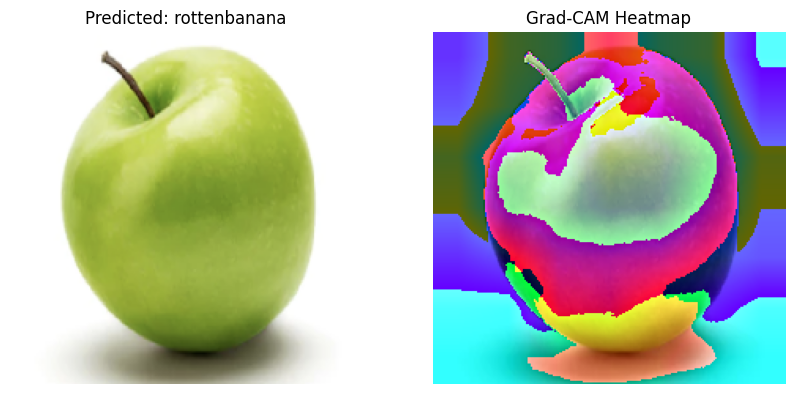

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import tensorflow as tf

def get_last_conv_layer():
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            print(" Selected Grad-CAM Layer:", layer.name)
            return layer.name
    raise ValueError(" No Conv2D layer found in model!")

last_conv_layer_name = get_last_conv_layer()

def make_gradcam_heatmap(img_array, class_index=None):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        if class_index is None:
            class_index = tf.argmax(preds[0])
        loss = preds[:, class_index]

    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_out = conv_out[0]
    heatmap = np.maximum(conv_out @ pooled_grads[..., tf.newaxis], 0)
    heatmap = heatmap.squeeze()
    heatmap = heatmap / (np.max(heatmap) + 1e-10)
    return heatmap, int(class_index)

def show_gradcam(image_path):
    img = image.load_img(image_path, target_size=IMG_SIZE)
    img_array = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)

    heatmap, pred_class = make_gradcam_heatmap(img_array)
    heatmap = cv2.resize(heatmap, IMG_SIZE)
    heatmap = np.uint8(255 * heatmap)

    img_orig = image.img_to_array(img) / 255.0
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    output = heatmap_color * 0.4 + img_orig * 255

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img_orig)
    plt.title(f"Predicted: {class_names[pred_class]}")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(np.uint8(output))
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.show()
show_gradcam("/content/drive/MyDrive/Fruit Freshnes/dataset/test/freshapples/Screen Shot 2018-06-08 at 4.59.44 PM.png")
